# Preparation

In [33]:
# Mengimpor library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [34]:
# Membaca data dari file CSV
df = pd.read_csv('BTC-USD-7-03-24.csv')

In [35]:
# Mengurutkan data berdasarkan kolom 'Tanggal'
df = df.sort_values('Date').reset_index(drop=True)

In [36]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-07,10803.900391,10929.500000,9692.120117,9965.570313,9965.570313,8797910016
1,2018-03-08,9951.440430,10147.400391,9335.870117,9395.009766,9395.009766,7186089984
2,2018-03-09,9414.690430,9466.349609,8513.030273,9337.549805,9337.549805,8704190464
3,2018-03-10,9350.589844,9531.320313,8828.469727,8866.000000,8866.000000,5386319872
4,2018-03-11,8852.780273,9711.889648,8607.120117,9578.629883,9578.629883,6296370176


In [37]:
# Menampilkan dimensi dataframe
df.shape

(2193, 7)

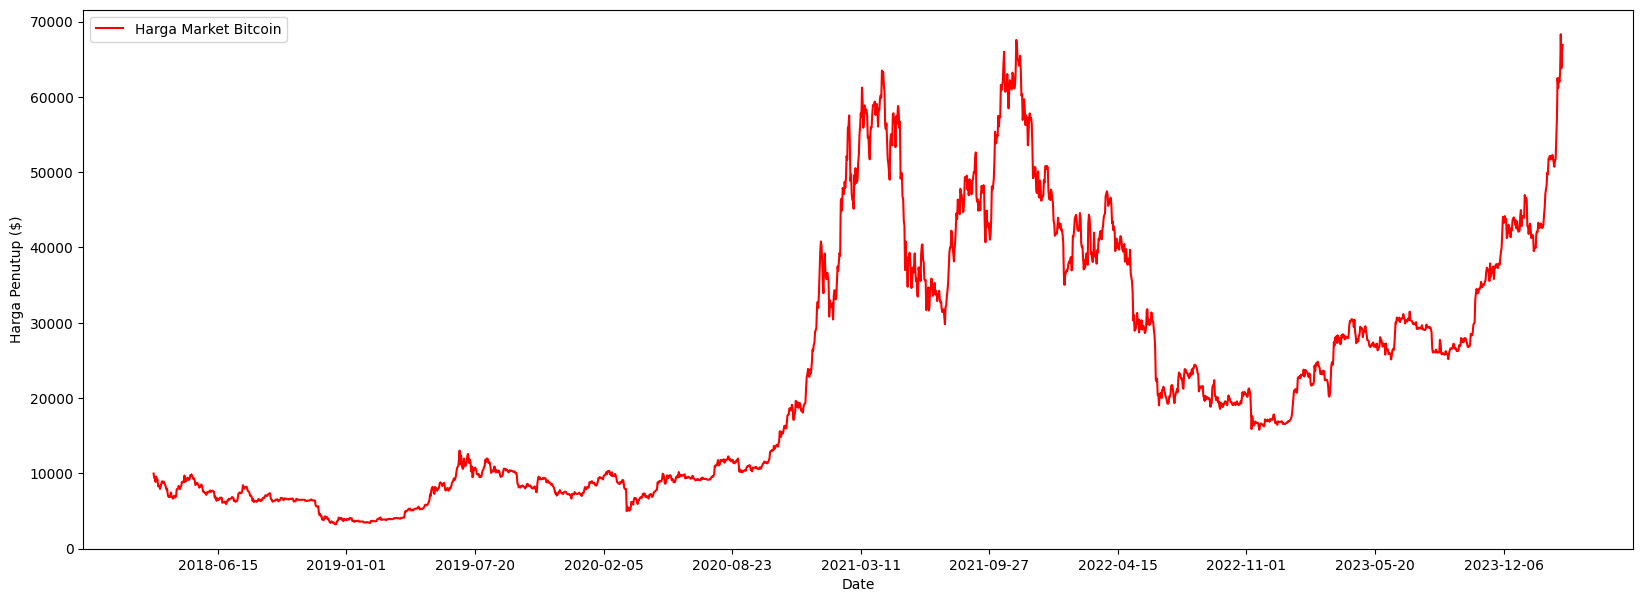

In [38]:
# Memilih kolom "Close" untuk harga harian
df['Close'] = df['Close'].astype(float)

# Menampilkan grafik harga saham harian Bitcoin
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['Close'].values, label='Harga Market Bitcoin', color='red')
plt.xticks(np.arange(100, df.shape[0], 200))
plt.xlabel('Date')
plt.ylabel('Harga Penutup ($)')
plt.legend()
plt.show()


## Data Preprocessing

In [39]:
#split data
num_shape = 2050

# Memilih kolom 'Close' sebagai data latih dan data uji
train = df.iloc[:num_shape, 1:2].values
test = df.iloc[num_shape:, 1:2].values

1. num_shape = 2100: Ini adalah sebuah variabel yang diberi nilai 2000. (data latih yang dipake)
2. train = df.iloc[:num_shape, 1:2].values: Ini adalah langkah pemisahan data untuk pelatihan.
    * df mungkin adalah sebuah DataFrame dalam pandas.
    * .iloc[] adalah metode untuk mengakses baris dan kolom berdasarkan posisi dalam DataFrame.
    * [:num_shape, 1:2] berarti kita mengambil baris dari awal sampai num_shape (2000) dan kolom kedua (indeks 1) hingga kolom ketiga (indeks 2).
    * .values mengambil nilai-nilai dari hasil slicing, mengubahnya menjadi bentuk array NumPy.
3. test = df.iloc[num_shape:, 1:2].values: Ini adalah langkah pemisahan data untuk pengujian.
    * Sama seperti sebelumnya, tetapi kali ini kita mengambil baris mulai dari indeks num_shape hingga akhir dan kolom kedua (indeks 1) hingga kolom ketiga (indeks 2).

    secara keseluruhan, membagi DataFrame df menjadi dua bagian: satu untuk pelatihan (dengan 2000 baris pertama) dan satu lagi untuk pengujian (dengan baris yang tersisa setelah 2000).


In [40]:
#normalisasi
# Membuat objek MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

# Melakukan normalisasi terhadap data latih
train_scaled = sc.fit_transform(train)

1. sc = MinMaxScaler(feature_range = (0, 1)): Ini membuat objek MinMaxScaler yang akan digunakan untuk melakukan penskalaan fitur. Parameter feature_range menentukan rentang nilai yang akan digunakan untuk penskalaan. Dalam kasus ini, rentangnya adalah dari 0 hingga 1, yang berarti semua fitur akan disesuaikan menjadi rentang tersebut.
2. train_scaled = sc.fit_transform(train): Ini menerapkan penskalaan fitur ke data pelatihan.
    * sc.fit_transform(train) akan menghitung parameter penskalaan (misalnya, nilai minimum dan maksimum) dari data pelatihan (train) dan kemudian menerapkan transformasi ke data tersebut.
    * Data hasil transformasi disimpan dalam variabel train_scaled.

secara keseluruhan, menghasilkan data pelatihan yang telah discaling (disesuaikan) sehingga nilai-nilainya berada dalam rentang antara 0 dan 1, menggunakan metode Min-Max Scaler. Hal ini umum dilakukan dalam pemrosesan data sebelum melatih model untuk memastikan bahwa semua fitur memiliki skala yang seragam.

In [41]:
X_train = []
y_train = []

window = 60 #periode

# Membuat data latih dan label dengan jendela (window)
for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])

# Mengubah list menjadi array numpy
X_train = np.stack(X_train)
y_train = np.stack(y_train)

1. X_train = [] dan y_train = []: Variabel X_train dan y_train diinisialisasi sebagai daftar kosong. X_train akan digunakan untuk menyimpan fitur-fitur (sering disebut sebagai "window") dan y_train akan digunakan untuk menyimpan target (dalam hal ini, harga hari selanjutnya).
2. window = 60: Variabel window menentukan jumlah periode waktu yang akan digunakan sebagai fitur untuk memprediksi harga hari selanjutnya. Dalam hal ini, digunakan jendela (window) dengan panjang 60.
3. Loop for i in range(window, num_shape): Ini adalah loop yang akan digunakan untuk membuat jendela bergeser di sepanjang data. Dimulai dari window (60) hingga num_shape (jumlah total data).
4. X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1)): Ini adalah langkah untuk mengambil jendela dari data yang telah discaling dan mengubahnya menjadi bentuk yang sesuai untuk digunakan sebagai fitur.
    * train_scaled[i-window:i, 0] mengambil 60 baris data terakhir dari data yang telah discaling (train_scaled) untuk digunakan sebagai fitur.
    * np.reshape(..., (window, 1)) mengubah dimensi data tersebut menjadi (window, 1), di mana window adalah panjang jendela dan 1 adalah jumlah fitur.
5. X_train.append(X_train_) dan y_train.append(train_scaled[i, 0]): Menambahkan jendela yang telah dibentuk dan harga hari selanjutnya ke dalam X_train dan y_train secara berturut-turut.
6. X_train = np.stack(X_train) dan y_train = np.stack(y_train): Mengubah daftar fitur dan target menjadi array numpy.
Jadi, secara keseluruhan, potongan kode ini menghasilkan fitur-fitur yang berbentuk jendela dengan panjang 60 (60 periode sebelumnya) dan target yang sesuai (harga hari selanjutnya) untuk digunakan dalam pelatihan model time series forecasting.

secara keseluruhan menghasilkan fitur-fitur yang berbentuk Window dengan panjang 60 (60 periode sebelumnya) dan target yang sesuai (harga hari selanjutnya) untuk digunakan dalam pelatihan model prediksi time series.

### Training Model LSTM

In [42]:
# Inisialisasi model
model = Sequential()

# Menambahkan layer LSTM pertama dengan dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Menambahkan layer LSTM kedua dengan dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Menambahkan layer LSTM ketiga dengan dropout
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Menambahkan layer LSTM keempat dengan dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Menambahkan layer output
model.add(Dense(units=1))

# Menampilkan ringkasan model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

1. LSTM Layer: LSTM adalah jenis layer dalam neural network yang biasanya digunakan untuk memproses data berurutan, seperti teks atau data deret waktu. Dalam model ini, terdapat empat layer LSTM yang masing-masing memiliki 50 unit neuron. Output shape dari LSTM layer adalah (None, 60, 50), yang berarti menerima input dengan panjang sekuen 60 dan menghasilkan output dengan dimensi 50.
2. Dropout Layer: Dropout adalah teknik regularisasi yang digunakan untuk mencegah overfitting dalam neural network. Dalam model ini, terdapat empat layer Dropout yang digunakan setelah setiap layer LSTM. Dropout layer ini memiliki dropout rate 0, yang berarti tidak ada neuron yang dinonaktifkan secara acak selama proses training.
3. Dense Layer: Dense layer adalah layer yang terhubung penuh, di mana setiap neuron di layer sebelumnya terhubung dengan setiap neuron di layer ini. Dalam model ini, terdapat satu Dense layer dengan satu neuron sebagai output.


In [43]:
# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
model.fit(X_train, y_train, epochs=30, batch_size=8)

Epoch 1/30
249/249 [==============================] - 35s 104ms/step - loss: 0.0084
Epoch 2/30
249/249 [==============================] - 28s 114ms/step - loss: 0.0044
Epoch 3/30
249/249 [==============================] - 25s 101ms/step - loss: 0.0031
Epoch 4/30
249/249 [==============================] - 26s 104ms/step - loss: 0.0032
Epoch 5/30
249/249 [==============================] - 26s 105ms/step - loss: 0.0026
Epoch 6/30
249/249 [==============================] - 26s 104ms/step - loss: 0.0022
Epoch 7/30
249/249 [==============================] - 26s 104ms/step - loss: 0.0022
Epoch 8/30
249/249 [==============================] - 25s 101ms/step - loss: 0.0020
Epoch 9/30
249/249 [==============================] - 25s 102ms/step - loss: 0.0019
Epoch 10/30
249/249 [==============================] - 26s 104ms/step - loss: 0.0019
Epoch 11/30
249/249 [==============================] - 29s 115ms/step - loss: 0.0017
Epoch 12/30
249/249 [==============================] - 26s 103ms/step - lo

1. model.compile(optimizer='adam', loss='mean_squared_error'): Ini adalah langkah kompilasi model.
    * optimizer='adam': Adam adalah algoritma optimisasi yang sering digunakan dalam pelatihan model.
    * loss='mean_squared_error': Ini adalah fungsi kerugian yang digunakan selama pelatihan. Dalam hal ini, kita menggunakan mean squared error (MSE), yang sering digunakan untuk masalah regresi.
2. model.fit(X_train, y_train, epochs=500, batch_size=128): Ini adalah langkah pelatihan model.
    * X_train adalah fitur-fitur yang telah disiapkan sebelumnya.
    * y_train adalah target yang sesuai.
    * epochs=500 menentukan jumlah epoch (iterasi melalui seluruh dataset) yang akan dilakukan selama pelatihan.
    * batch_size=128 menentukan ukuran batch yang akan digunakan dalam pelatihan. Di sini, 128 adalah ukuran batch yang dipilih. (128 sample data/data latih)

pembagian batch dengan data latih



## Prediksi

In [44]:
# Menggabungkan data latih dan data uji
df_volume = np.vstack((train, test))

# Mengambil data harga penutupan dari data uji dan beberapa data sebelumnya
inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1, 1)

# Melakukan normalisasi terhadap data uji dengan menggunakan MinMaxScaler yang sama
inputs = sc.transform(inputs)

# Jumlah data uji setelah penambahan jendela
num_2 = df_volume.shape[0] - num_shape + window

X_test = []

# Membuat data uji dengan jendela yang sama seperti pada data latih
for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)

# Mengubah list menjadi array numpy
X_test = np.stack(X_test)

In [45]:
# Membuat prediksi menggunakan model
prediksi = model.predict(X_test)

# Mengembalikan prediksi ke skala aslinya
prediksi = sc.inverse_transform(prediksi)

5/5 [==============================] - 2s 32ms/step


In [46]:
# Menghitung perbedaan antara prediksi dan nilai aktual
diff = prediksi - test

# Menghitung MSE (Mean Squared Error)
MSE = np.mean(diff**2)

# Menghitung MAE (Mean Absolute Error)
MAE = np.mean(abs(diff))

# Menghitung RMSE (Root Mean Squared Error)
RMSE = np.sqrt(MSE)

# Menampilkan hasil evaluasi
print("MSE:", MSE)
print("MAE:", MAE)
print("RMSE:", RMSE)

MSE: 2263096.3326708567
MAE: 1113.2213723181821
RMSE: 1504.3591102761523


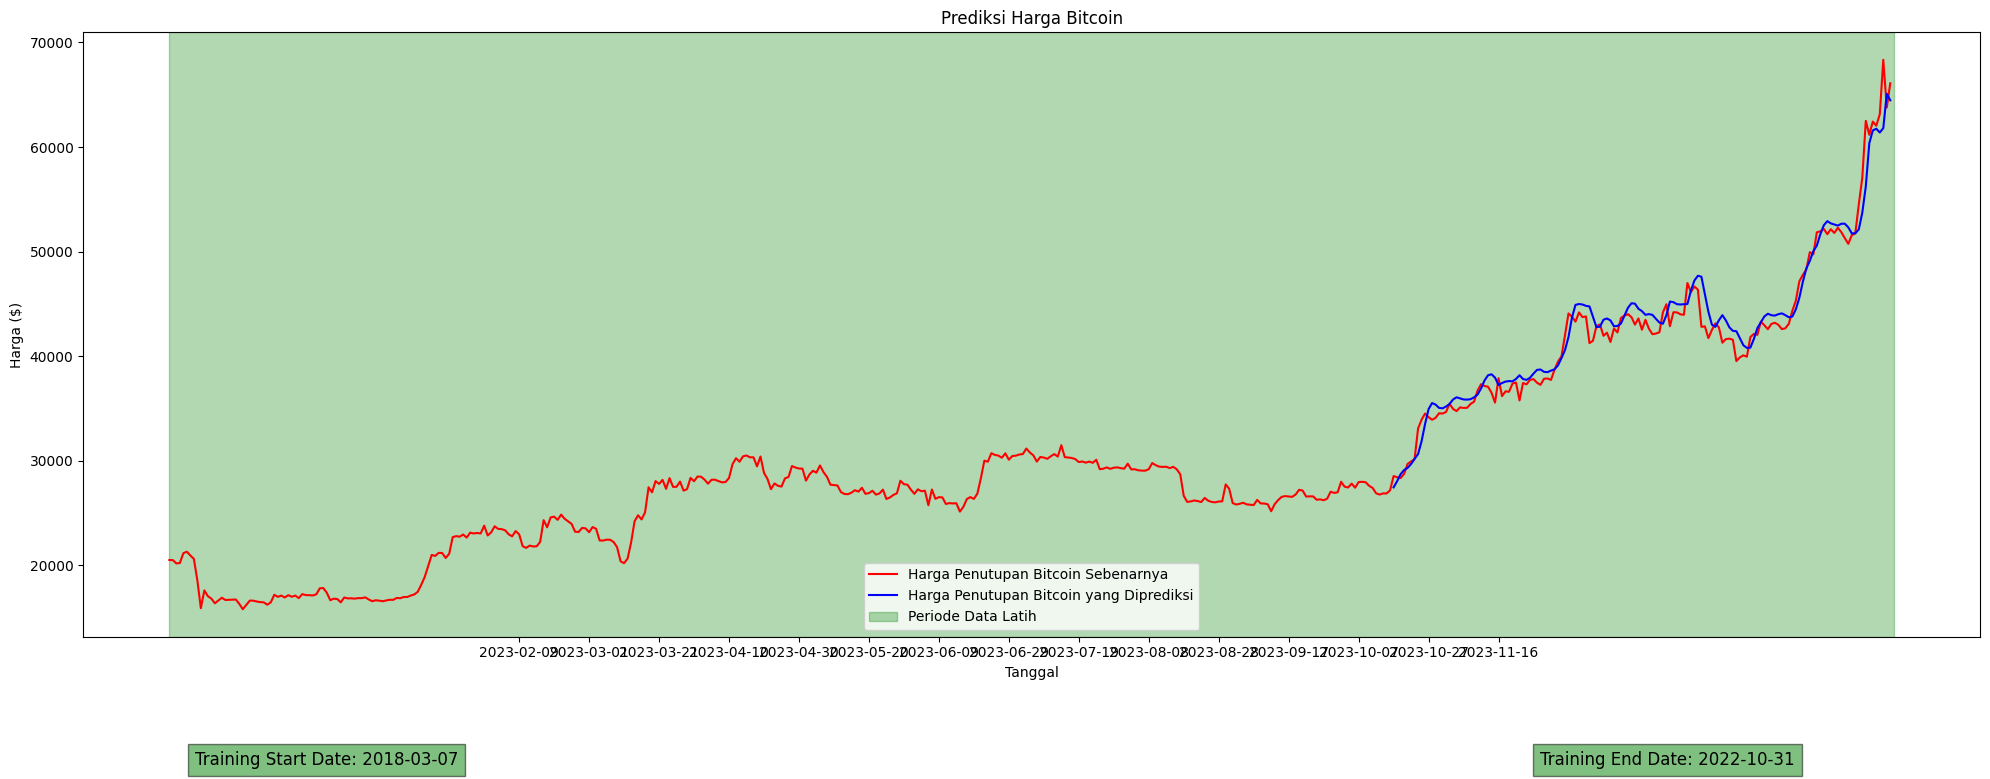

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Mengatur ukuran plot
plt.figure(figsize=(20, 7))

# Plot harga penutupan aktual Bitcoin
plt.plot(df['Date'].values[1700:], df_volume[1700:], color='red', label='Harga Penutupan Bitcoin Sebenarnya')

# Plot harga penutupan yang diprediksi oleh model
plt.plot(df['Date'][-prediksi.shape[0]:].values, prediksi, color='blue', label='Harga Penutupan Bitcoin yang Diprediksi')

# Menambahkan tanggal yang digunakan untuk pelatihan model
plt.axvspan(df['Date'].values[0], df['Date'].values[1700], color='green', alpha=0.3, label='Periode Data Latih')

# Menampilkan rentang tanggal pelatihan di bawah plot
start_date = df['Date'].values[0]
end_date = df['Date'].values[1699]

# Menambahkan anotasi di bawah plot
plt.figtext(0.1, -0.1, f'Training Start Date: {start_date}', ha='left', fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":5})
plt.figtext(0.9, -0.1, f'Training End Date: {end_date}', ha='right', fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":5})

# Menandai label sumbu x
plt.xticks(np.arange(100, df[1800:].shape[0], 20))

# Menambahkan judul dan label sumbu
plt.title('Prediksi Harga Bitcoin')
plt.xlabel('Tanggal')
plt.ylabel('Harga ($)')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

# Testing LSTM

In [48]:
pred_ = prediksi[-1].copy() # Mengambil prediksi terakhir dari model sebelumnya
prediksi_full = [] # Inisialisasi list untuk menyimpan prediksi
df_copy = df.iloc[:, 1:2][1:].values.copy() # Mendefinisikan df_copy

# Loop untuk membuat prediksi untuk beberapa periode ke depan
for j in range(10):
    # Menggabungkan data harga Bitcoin aktual dengan prediksi terakhir
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape] # Bagian data latih
    test_ = df_[num_shape:] # Bagian data uji

    df_volume_ = np.vstack((train_, test_)) # Menggabungkan data latih dan data uji

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:] # Memilih input untuk prediksi
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_) # Melakukan normalisasi terhadap input

    X_test_2 = []

    # Loop untuk membuat data uji dengan jendela
    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)

    # Melakukan prediksi harga
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_) # Mengembalikan prediksi ke skala aslinya
    prediksi_full.append(pred_[-1][0]) # Menambahkan prediksi terakhir ke list
    df_copy = df_[j:] # Memperbarui data dengan menambahkan prediksi terakhir

5/5 [==============================] - 0s 32ms/step


In [49]:
# Menggabungkan prediksi model sebelumnya dengan prediksi untuk beberapa periode ke depan
prediksi_full_new = np.vstack((prediksi, np.array(prediksi_full).reshape(-1,1)))

In [50]:
import pandas as pd

# Memilih kolom 'Date' dari DataFrame asli
df_date = df[['Date']]

# Loop untuk menambahkan tanggal untuk 10 hari ke depan
for h in range(10):
    # Menambahkan 1 hari ke tanggal terakhir
    df_date_add = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)

    # Membuat DataFrame baru dengan tanggal yang ditambahkan
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d")], columns=['Date'])

    # Menggabungkan DataFrame baru ke DataFrame utama
    df_date = pd.concat([df_date, df_date_add], ignore_index=True)

<ipython-input-51-289f36ea0477>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_predicted_price = float(prediksi_full_new[-1])  # Convert to scalar


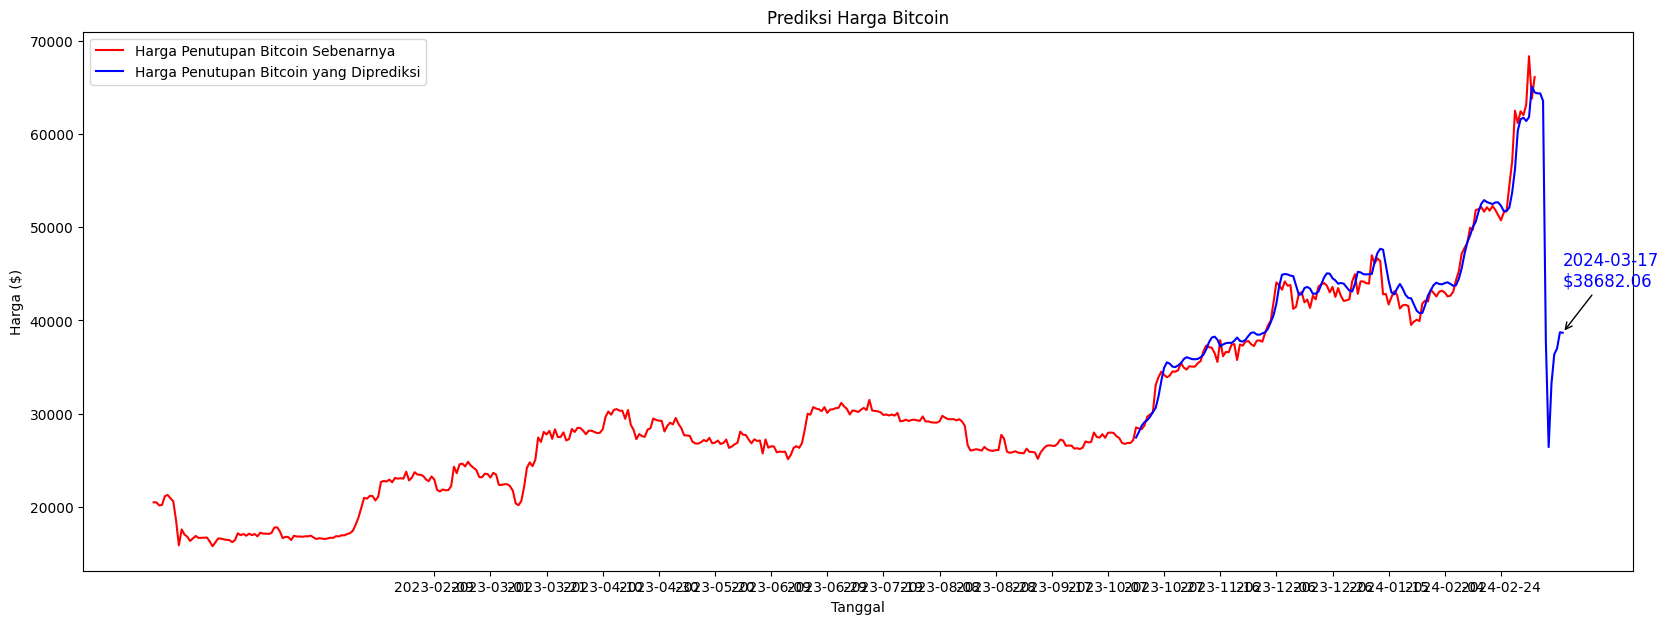

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,7))

# Plot harga penutupan aktual Bitcoin
plt.plot(df['Date'].values[1700:], df_volume[1700:], color='red', label='Harga Penutupan Bitcoin Sebenarnya')

# Plot tanggal dan harga penutupan yang diprediksi
plt.plot(df_date['Date'][-prediksi_full_new.shape[0]:].values, prediksi_full_new, color='blue', label='Harga Penutupan Bitcoin yang Diprediksi')

# Menandai label sumbu x
plt.xticks(np.arange(100, df[1700:].shape[0], 20))

# Menambahkan judul dan label sumbu
plt.title('Prediksi Harga Bitcoin')
plt.xlabel('Tanggal')
plt.ylabel('Harga ($)')

# Menambahkan legenda
plt.legend()

# Menambahkan anotasi untuk harga penutupan yang diprediksi terakhir
if prediksi_full_new.size > 0:
    last_predicted_date = df_date['Date'].values[-prediksi_full_new.shape[0]:][-1]
    last_predicted_price = float(prediksi_full_new[-1])  # Convert to scalar
    plt.annotate(f'{last_predicted_date}\n${last_predicted_price:.2f}',
                 xy=(last_predicted_date, last_predicted_price),
                 xytext=(last_predicted_date, last_predicted_price + 5000), # Adjust the position as needed
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12, color='blue')

# Menampilkan plot
plt.show()

# GRU

In [52]:
# Membuat model GRU
modelGRU = Sequential()

# Menambahkan layer GRU pertama dengan dropout
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

# Menambahkan layer GRU kedua dengan dropout
modelGRU.add(GRU(units=50, return_sequences=True))
modelGRU.add(Dropout(0.2))

# Menambahkan layer GRU ketiga dengan dropout
modelGRU.add(GRU(units=50, return_sequences=True))
modelGRU.add(Dropout(0.2))

# Menambahkan layer GRU keempat dengan dropout
modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

# Menambahkan layer output
modelGRU.add(Dense(units=1))

# Menampilkan ringkasan model
modelGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

In [53]:
# Kompilasi model GRU
modelGRU.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model GRU
modelGRU.fit(X_train, y_train, epochs=30, batch_size=8)

Epoch 1/30
249/249 [==============================] - 35s 109ms/step - loss: 0.0059
Epoch 2/30
249/249 [==============================] - 27s 108ms/step - loss: 0.0034
Epoch 3/30
249/249 [==============================] - 27s 108ms/step - loss: 0.0025
Epoch 4/30
249/249 [==============================] - 27s 108ms/step - loss: 0.0020
Epoch 5/30
249/249 [==============================] - 27s 109ms/step - loss: 0.0022
Epoch 6/30
249/249 [==============================] - 27s 107ms/step - loss: 0.0022
Epoch 7/30
249/249 [==============================] - 27s 107ms/step - loss: 0.0020
Epoch 8/30
249/249 [==============================] - 27s 109ms/step - loss: 0.0019
Epoch 9/30
249/249 [==============================] - 32s 129ms/step - loss: 0.0017
Epoch 10/30
249/249 [==============================] - 29s 114ms/step - loss: 0.0021
Epoch 11/30
249/249 [==============================] - 28s 110ms/step - loss: 0.0018
Epoch 12/30
249/249 [==============================] - 28s 111ms/step - lo

In [54]:
# Membuat prediksi menggunakan model GRU
prediksi_GRU = modelGRU.predict(X_test)

# Mengembalikan prediksi ke skala aslinya
prediksi_GRU = sc.inverse_transform(prediksi_GRU)

5/5 [==============================] - 2s 28ms/step


In [55]:
# Menghitung perbedaan antara prediksi dan nilai aktual
diff_GRU = prediksi_GRU - test

# Menghitung MSE (Mean Squared Error)
MSE_GRU = np.mean(diff_GRU**2)

# Menghitung MAE (Mean Absolute Error)
MAE_GRU = np.mean(abs(diff_GRU))

# Menghitung RMSE (Root Mean Squared Error)
RMSE_GRU = np.sqrt(MSE_GRU)

# Menampilkan hasil evaluasi
print("MSE:", MSE_GRU)
print("MAE:", MAE_GRU)
print("RMSE:", RMSE_GRU)

MSE: 3544175.048504316
MAE: 1591.9092547045464
RMSE: 1882.5979519016576


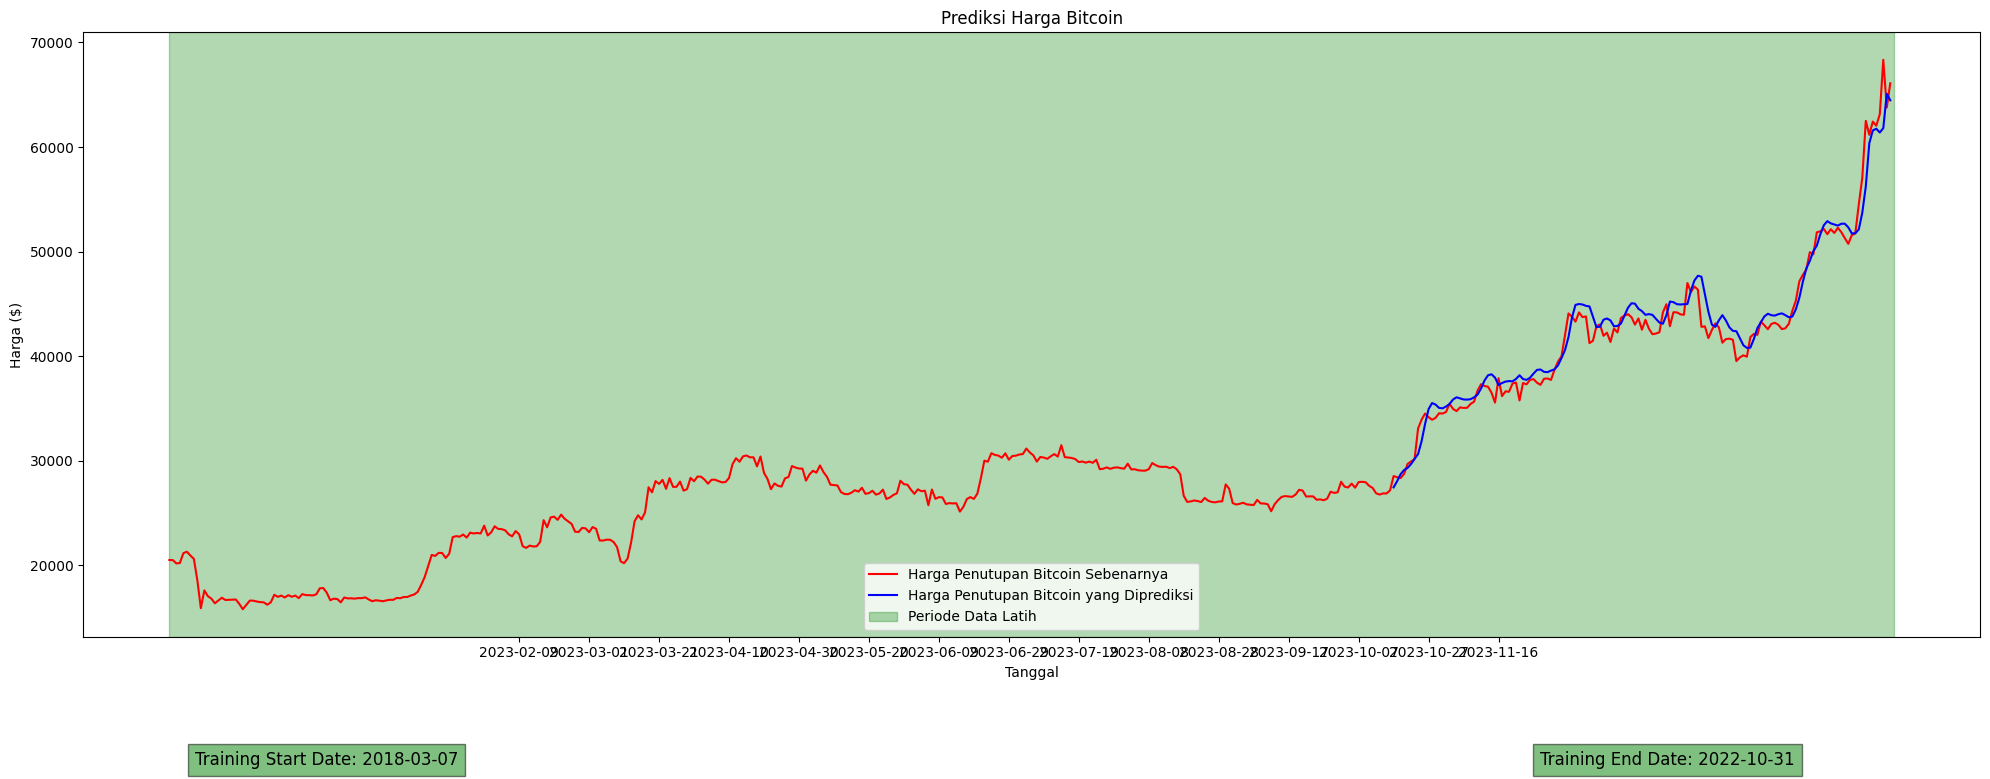

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Mengatur ukuran plot
plt.figure(figsize=(20, 7))

# Plot harga penutupan aktual Bitcoin
plt.plot(df['Date'].values[1700:], df_volume[1700:], color='red', label='Harga Penutupan Bitcoin Sebenarnya')

# Plot harga penutupan yang diprediksi oleh model
plt.plot(df['Date'][-prediksi.shape[0]:].values, prediksi, color='blue', label='Harga Penutupan Bitcoin yang Diprediksi')

# Menambahkan tanggal yang digunakan untuk pelatihan model
plt.axvspan(df['Date'].values[0], df['Date'].values[1700], color='green', alpha=0.3, label='Periode Data Latih')

# Menampilkan rentang tanggal pelatihan di bawah plot
start_date = df['Date'].values[0]
end_date = df['Date'].values[1699]

# Menambahkan anotasi di bawah plot
plt.figtext(0.1, -0.1, f'Training Start Date: {start_date}', ha='left', fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":5})
plt.figtext(0.9, -0.1, f'Training End Date: {end_date}', ha='right', fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":5})

# Menandai label sumbu x
plt.xticks(np.arange(100, df[1800:].shape[0], 20))

# Menambahkan judul dan label sumbu
plt.title('Prediksi Harga Bitcoin')
plt.xlabel('Tanggal')
plt.ylabel('Harga ($)')

# Menambahkan legenda
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

# TESTING GRU

In [57]:
pred_ = prediksi_GRU[-1].copy() # Mengambil prediksi terakhir dari model GRU sebelumnya
prediksi_full = [] # Inisialisasi list untuk menyimpan prediksi
df_copy = df.iloc[:, 1:2][1:].values.copy() # Mendefinisikan df_copy

# Loop untuk membuat prediksi untuk beberapa periode ke depan
for j in range(20):
    # Menggabungkan data harga Bitcoin aktual dengan prediksi terakhir
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape] # Bagian data latih
    test_ = df_[num_shape:] # Bagian data uji

    df_volume_ = np.vstack((train_, test_)) # Menggabungkan data latih dan data uji

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:] # Memilih input untuk prediksi
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_) # Melakukan normalisasi terhadap input

    X_test_2 = []

    # Loop untuk membuat data uji dengan jendela
    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)

    # Melakukan prediksi harga
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_) # Mengembalikan prediksi ke skala aslinya
    prediksi_full.append(pred_[-1][0]) # Menambahkan prediksi terakhir ke list
    df_copy = df_[j:] # Memperbarui data dengan menambahkan prediksi terakhir

5/5 [==============================] - 0s 32ms/step


In [58]:
import pandas as pd
import numpy as np

# Dengan asumsi `prediksi_GRU` dan `prediksi_full` telah didefinisikan di tempat lain
prediksi_full_baru = np.vstack((prediksi_GRU, np.array(prediksi_full).reshape(-1,1)))

# Membuat DataFrame dengan hanya kolom 'Tanggal' dari df
df_date = df[['Date']]

# Loop untuk menambahkan 20 tanggal baru ke df_date
for h in range(20):
    # Menghasilkan tanggal baru dengan menambahkan satu hari ke tanggal terakhir di df_date
    tanggal_baru = pd.to_datetime(df_date['Date'].iloc[-1]) + pd.DateOffset(days=1)
    # Membuat DataFrame dengan tanggal baru
    df_tanggal_baru = pd.DataFrame([tanggal_baru.strftime("%Y-%m-%d")], columns=['Date'])
    # Menggabungkan DataFrame tanggal baru dengan df_date
    df_date = pd.concat([df_date, df_tanggal_baru], ignore_index=True)

# Mereset indeks df_date
df_date = df_date.reset_index(drop=True)

<ipython-input-59-a6be037e40fd>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_price = float(prediksi_full_baru[-1])


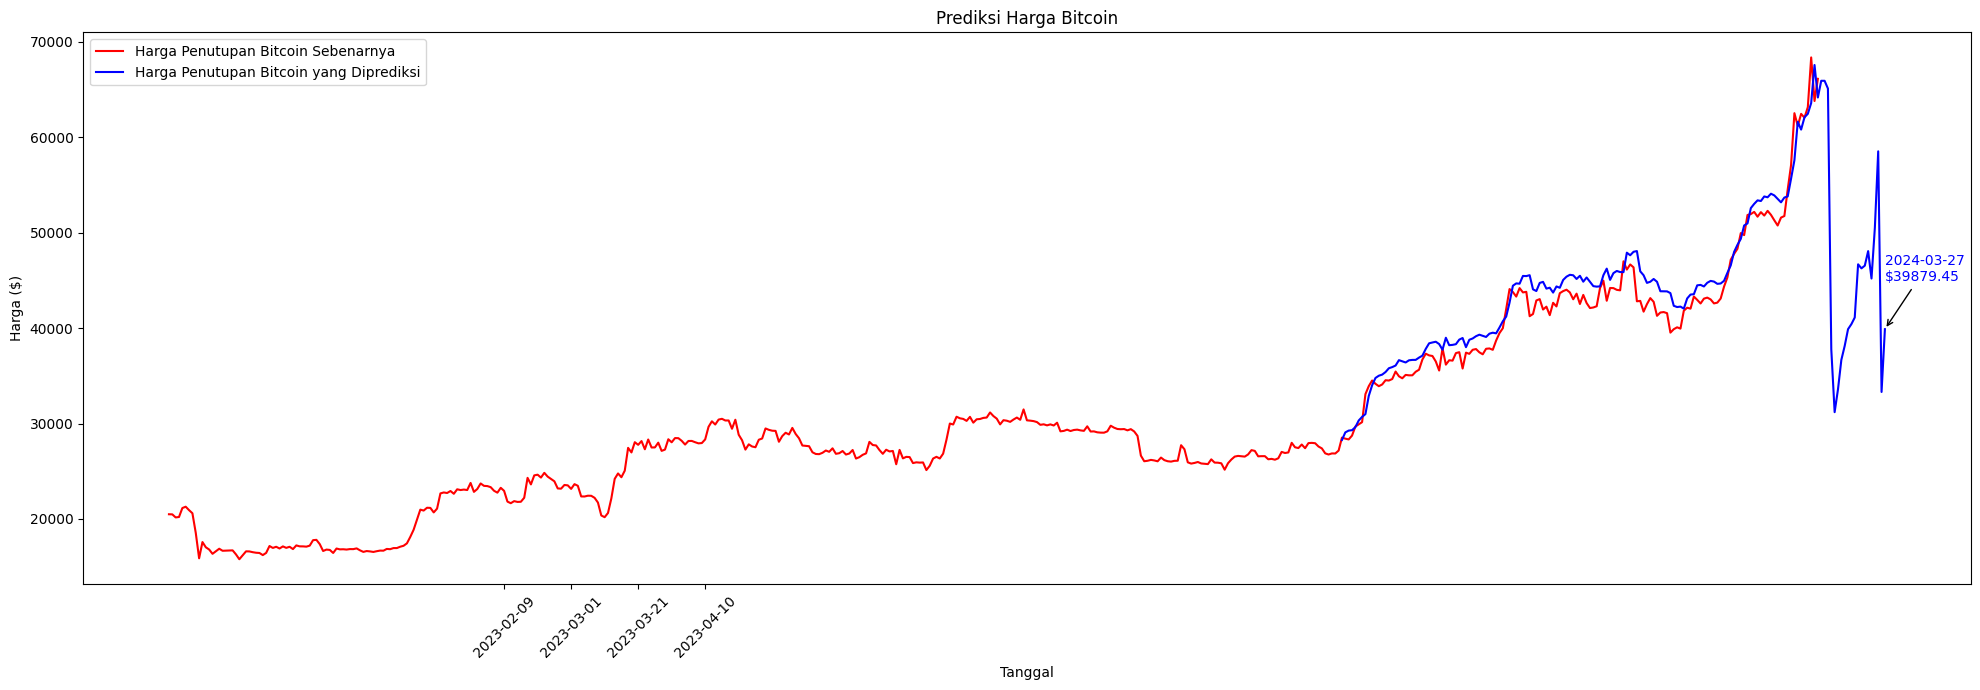

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,7))

# Plot harga penutupan aktual Bitcoin
plt.plot(df['Date'].values[1700:], df_volume[1700:], color='red', label='Harga Penutupan Bitcoin Sebenarnya')

# Plot tanggal dan harga penutupan yang diprediksi
prediksi_dates = df_date['Date'].values[-prediksi_full_baru.shape[0]:]
plt.plot(prediksi_dates, prediksi_full_baru, color='blue', label='Harga Penutupan Bitcoin yang Diprediksi')

# Menandai label sumbu x
plt.xticks(np.arange(100, len(prediksi_dates), 20), rotation=45)

# Menambahkan judul dan label sumbu
plt.title('Prediksi Harga Bitcoin')
plt.xlabel('Tanggal')
plt.ylabel('Harga ($)')

# Menambahkan legenda
plt.legend()

# Menambahkan anotasi untuk prediksi terakhir
last_date = str(prediksi_dates[-1])
last_price = float(prediksi_full_baru[-1])
plt.annotate(f'{last_date}\n${last_price:.2f}',
             xy=(last_date, last_price),
             xytext=(last_date, last_price + 5000),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [60]:
# Calculate standard error for LSTM model
n = len(diff)
std_error_LSTM = np.std(diff) / np.sqrt(n)
print("Standard Error (LSTM):", std_error_LSTM)

Standard Error (LSTM): 120.9959627316367


In [61]:
# Calculate standard error for GRU model
n_GRU = len(diff_GRU)
std_error_GRU = np.std(diff_GRU) / np.sqrt(n_GRU)
print("Standard Error (GRU):", std_error_GRU)

Standard Error (GRU): 118.98125932354495


In [62]:
# Calculate and display the difference in standard error
std_error_diff = std_error_LSTM - std_error_GRU
print("Difference in Standard Error:", std_error_diff)

Difference in Standard Error: 2.014703408091748
